In [2]:
import os
import cv2

def load_image(img_path, img_size):
    image = cv2.imread(img_path)
    height, width, _ = image.shape
    diff = height-width
    if diff > 0:
        image = cv2.copyMakeBorder(image, 0, 0, diff//2, diff//2, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    elif diff < 0:
        image = cv2.copyMakeBorder(image, -diff//2, -diff//2, 0, 0, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # image = np.expand_dims(image, -1)
    return image

def angle_difference(a, b):
    return 180 - abs(abs(a - b) - 180)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl
import torchmetrics as tm
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import numpy as np

import matplotlib.pyplot as plt

import random

class RandomResizedCenterCrop(torch.nn.Module):
    def __init__(self, max_crop_ratio=0.8):
        super().__init__()
        self.max_crop_ratio = max_crop_ratio

    def forward(self, img):
        _, H, W = img.size()
        size = torch.LongTensor([H, W])

        ratio = torch.rand(1) * (1-self.max_crop_ratio) + self.max_crop_ratio
        crop_size = (size * ratio).int().tolist()

        img = TF.center_crop(img, crop_size)
        img = TF.resize(img, size.tolist(), interpolation=transforms.InterpolationMode.BILINEAR)

        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(max_crop_ratio={self.max_crop_ratio})"

class SinksTrain(data.Dataset):
    def __init__(self, classes, split='train', img_size=40, ratio=0.4):
        self.classes = classes
        self.folder = f'../sinks/{split}/'
        self.files = os.listdir(self.folder)[1:] # remove A_wrong
        self.normal_files = [f for f in self.files if 'Corner' not in f]
        self.corner_files = [f for f in self.files if 'Corner' in f]
        
        # let x be the factor we need to multiply the number of elements in c
        # to meet the ratio between classes
        # c * x = ratio * (c*x + n)
        # by solving for x we get:
        # x = (ratio*n)/((1-ratio)*c)

        if ratio != None:
            n = len(self.files)
            c = len(self.corner_files)
            needed_factor = (ratio*n)/((1-ratio)*c)
            self.corner_files = self.corner_files*int(needed_factor)

        self.sink_files = self.normal_files + self.corner_files
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
        ])
        self.resize = RandomResizedCenterCrop(0.75)

    def __len__(self):
        return len(self.sink_files)

    def __getitem__(self, idx):
        name = self.sink_files[idx]
        img = load_image(self.folder + name, self.img_size)
        img = np.moveaxis(img, 2, 0)
        img = (img / 255) * 2 - 1
        img = torch.tensor(img).float()
        img = self.transform(img)

        rot = random.choice(self.classes[:-1])
        img = TF.rotate(img, rot, interpolation=transforms.InterpolationMode.BILINEAR, fill=1)

        img = self.resize(img)

        return img, len(self.classes) - 1 if 'Corner' in name else rot//(360//(len(self.classes)-1))

class SinksEval(data.Dataset):
    def __init__(self, classes, split, n_samples=None, img_size=40, seed=0, ratio=0.3):
        self.classes = classes
        self.folder = f'../sinks/{split}/'
        self.files = os.listdir(self.folder)[1:] # remove A_wrong
        self.normal_files = [f for f in self.files if 'Corner' not in f]
        self.corner_files = [f for f in self.files if 'Corner' in f]

        if ratio != None:
            n = len(self.files)
            c = len(self.corner_files)
            needed_factor = (ratio*n)/((1-ratio)*c)
            self.corner_files = self.corner_files*int(needed_factor)

        self.sink_files = self.normal_files + self.corner_files       

        self.sink_files = [f+'@'+str(c) for f in self.files for c in classes[:-1]]


        if n_samples != None:
            random.seed(seed)
            self.sink_files = random.sample(self.sink_files, n_samples)

        self.img_size = img_size
        self.split = split

    def __len__(self):
        return len(self.sink_files)

    def __getitem__(self, idx):
        name = self.sink_files[idx]
        name, rot = name.split('@')
        rot = int(rot)

        img = load_image(self.folder + name, self.img_size)
        img = np.moveaxis(img, 2, 0)
        img = (img / 255) * 2 - 1
        img = torch.tensor(img).float()

        img = TF.rotate(img, rot, interpolation=transforms.InterpolationMode.BILINEAR, fill=1)

        return img, len(self.classes) - 1 if 'Corner' in name else rot//(360//(len(self.classes)-1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1458


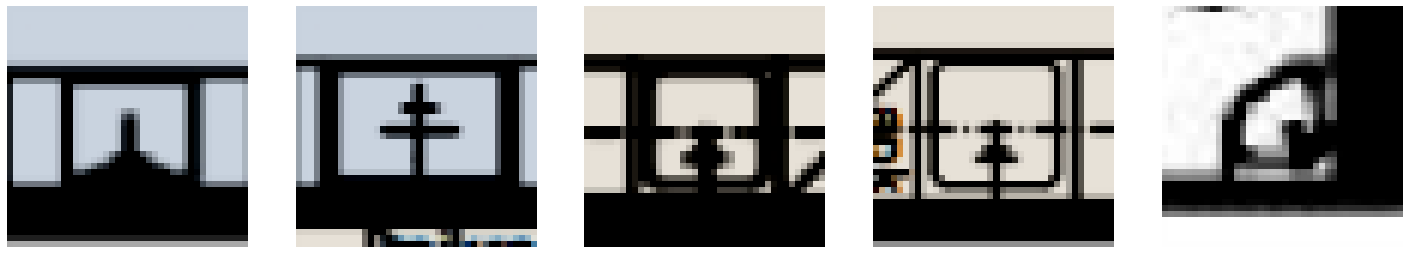

In [4]:
classes = list(range(0, 360, 45)) + ['corner']

s = SinksEval(classes, 'test', None)

stride = 5
n_figs = 5
fig_size = 5

fig, axes = plt.subplots(1, n_figs, figsize = (fig_size*n_figs, fig_size))

for i in range(0, stride*n_figs*8, stride*8):
    img, rot = s[i]
    idx = i//(stride*len(classes))
    axes[idx].axis('off')
    axes[idx].imshow(img.permute(1,2,0))

corner_idx = [i for (i, f) in enumerate(s.sink_files) if 'Corner' in f][10]
print(corner_idx)

axes[-1].axis('off')
axes[-1].imshow(s[corner_idx][0].permute(1,2,0))

# fig.savefig('sinks_examples.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


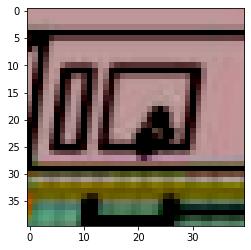

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


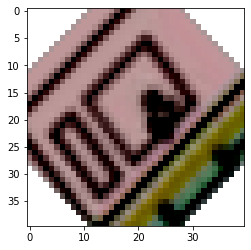

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


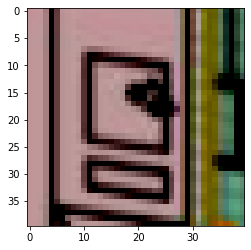

In [5]:

s = SinksEval(classes, 'test', None)
t = SinksTrain(classes)
for i in range(3):
    im, rot = s[i]
    print(rot)
    plt.imshow(im.permute(1,2,0))
    plt.show()

In [6]:
def labels_to_angles(labels, classes):
    return labels*(360//len(classes))

def tensor_angle_diff(preds, gt):
    return 180 - torch.abs(torch.abs(preds - gt) - 180)

# testloader = data.DataLoader(SinksEval(classes, 'test', 1000), batch_size=4, num_workers=1)
# x, y = next(iter(testloader))

# gt_angles = labels_to_angles(y, classes)
# print(gt_angles)
# preds = torch.LongTensor([225, 135, 135, 90])
# print(preds)
# print(tensor_angle_diff(gt_angles, preds))

In [7]:
import torchvision.models as models

class Net(pl.LightningModule):

    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.n_classes = len(classes)

        self.net = models.convnext_tiny(pretrained=True)
        in_features = self.net.classifier[2].in_features
        self.net.classifier[2] = nn.Linear(in_features, self.n_classes)

        self.accuracy = tm.Accuracy()


    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        self.log("train_ce_loss", ce_loss, prog_bar=True)

        return ce_loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        self.log("val_acc", self.accuracy, prog_bar=True)
        self.log("val_ce_loss", ce_loss, prog_bar=True)

        return ce_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        self.log("test_acc", self.accuracy, prog_bar=True)
        self.log("test_ce_loss", ce_loss, prog_bar=True)

        return ce_loss
 
    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [8]:
name = 'sinks-classification'
version = 'bgr_ce_40'
classes = list(range(0, 360, 45)) + ['corner']
model = Net(classes)

trainloader = data.DataLoader(SinksTrain(classes), batch_size=64, shuffle=True, num_workers=6)
valloader = data.DataLoader(SinksEval(classes, 'val', 1000), batch_size=64, num_workers=6)
# valloader = data.DataLoader(ToiletsTrain(classes), batch_size=64, num_workers=6)

logger = pl.loggers.TensorBoardLogger('../lightning_logs', name=name, version=version)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=-1,
    logger=logger,
    log_every_n_steps=20,
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        pl.callbacks.ModelCheckpoint(monitor="val_ce_loss", save_last=True, save_top_k=3, filename='{epoch}-{val_ce_loss:.3f}-{val_acc:.3f}')
    ],
)

/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, trainloader, valloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | net      | ConvNeXt | 27.8 M
1 | accuracy | Accuracy | 0     
--------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
111.308   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/mnt/c/Users/joaodavid/Desktop/CubiCasa5k/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
testloader = data.DataLoader(SinksEval(classes, 'test', ratio=None), batch_size=64, num_workers=6)
import time
start = time.time()
iters = 1
for i in range(iters):
    trainer.test(model, testloader, ckpt_path=f'../lightning_logs/{name}/{version}/checkpoints/epoch=32-val_ce_loss=0.058-val_acc=0.988.ckpt')
print((time.time() - start)/iters)

In [ ]:
from tqdm import tqdm

testloader = data.DataLoader(SinksEval(classes, 'test', ratio=None), batch_size=64, num_workers=1)
print(len(SinksEval(classes, 'test', ratio=None)))
all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader):
        preds = model(x).argmax(1).numpy()
        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

In [ ]:
import seaborn as sn

cm = tm.ConfusionMatrix(len(classes))
matrix = cm(all_preds, all_gt).numpy()

np.savetxt('sinks_cm.txt', cm, fmt='%d')
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax = sn.heatmap(matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('sinks_results.svg')
plt.show()

In [ ]:
tp = np.diag(matrix)
acc = tp/np.sum(matrix, axis=1)
precision = tp/np.sum(matrix, axis=0)

print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision]))

In [ ]:
torch.save(model.state_dict(), 'toilet-network.pth')

In [ ]:
# model = Net.load_from_checkpoint('../lightning_logs/toilets-classification/bgr_ce/checkpoints/last.ckpt', classes=classes)

class RawNet(nn.Module):

    def __init__(self, classes):
        super().__init__()

        self.classes = classes
        self.n_classes = len(classes)

        self.net = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        in_features = self.net.classifier[2].in_features
        self.net.classifier[2] = nn.Linear(in_features, self.n_classes)

    def forward(self, x):
        return self.net(x)


model2 = RawNet(classes)
model2.load_state_dict(torch.load('toilet-network.pth'))

In [ ]:
testloader = data.DataLoader(ToiletsEval(classes, 'test', None), batch_size=16, num_workers=1)

with torch.no_grad():
    for idx, (img, label) in enumerate(iter(testloader)):
        if all_preds[idx] != all_gt[idx]:
            img_rgb = ((img.numpy() + 1)/2 * 255).astype(np.int)[0]
            img_rgb = np.moveaxis(img_rgb, 0, 2)
            im, rot = t[idx]
            plt.imshow(im.permute(1,2,0))
            plt.show()
            # plt.imshow(img_rgb)
            # plt.show()
            print(f'Expected: {all_gt[idx]*(360//len(classes))}')
            # predict = model(img).argmax().item()
            print(f'Got: {all_preds[idx]*(360//len(classes))}')
            # print(f'Classified as: {predict*(360//len(classes))}')
            
        

In [ ]:
example = iter(testloader)

In [ ]:
testloader = data.DataLoader(Doors('test'), batch_size=1, num_workers=1)
testiter = iter(testloader)

In [ ]:
example = next(testiter)
img, label = example
img_rgb = ((img.numpy() + 1)/2 * 255).astype(int)[0]
img_rgb = np.moveaxis(img_rgb, 0, 2)
print(f'Expected: {label[0]}: {classes[label]}')
model2.eval()
predict = model(img).argmax().item()
print(f'Got: {predict}: {classes[predict]}')
plt.imshow(img_rgb)


In [ ]:
model.eval()
predict = model(img).argmax().item()
print(f'{predict}: {classes[predict]}')